# IFT3395 - Devoir 3 - partie 2

### Implémentation matricielle et tests - Questions 6 à 10

19 décembre 2015

- Pierre-Luc Pigeon
- Giancarlo Rizzi
- Vincent Antaki


##### Imports

In [1]:
%pylab inline
import numpy as np
import gzip,pickle
import os
import matplotlib.cbook
import time
warnings.filterwarnings("ignore")

from scipy.interpolate import interp1d
import matplotlib.pyplot as plt


Populating the interactive namespace from numpy and matplotlib


##### Misc functions

In [11]:
class Params:
    def __init__(self, W1, W2, b1, b2):
        self.W1 = W1
        self.W2 = W2
        self.b1 = b1
        self.b2 = b2

#init une matrice W avec des poids uniforme sur l'intervalle du devoir
def init_matrix(row, col):
    v= 1.0 /np.sqrt(col)
    result = np.random.uniform(low=(-1*v), high=v, size=(row,col) )
    return result

def rect(v):
    return np.maximum(np.zeros(v.shape),v);

def rectPrime(v):
    return np.greater(v, np.zeros(v.shape)).astype(int)

def onehot(m, y):
    result = np.zeros(m)
    result[np.arange(m[0]), y.astype(int)] = 1
    return result

def softmax(a):
    """ Stable implementation on softmax function """
    a_max = np.max(a, axis=1)
    
    s = np.exp(a - np.tile(a_max, (a.shape[1],1)).T)
    
    # normalisation_factor
    n = np.sum(s, axis=1)
    n = 1.0/np.tile(n, (s.shape[1], 1))
       
    return np.multiply(s,n.T)

#Timing function
#Taken from stack overflow (URL lost)
def timeit(f):
    def wrap(*args):
        time1 = time.time()
        ret = f(*args)
        time2 = time.time()
        print('%s function took %0.3f ms' % (f.func_name, (time2-time1)*1000.0))
        return ret
    return wrap

print(rect(np.array([3,4,5,6,-2, 0.2, -9])))
print(rectPrime(np.array([3,4,5,6,-2, 0.2, -9])))
print(softmax(np.array([[1,1,1]])))

[ 3.   4.   5.   6.   0.   0.2  0. ]
[1 1 1 1 0 1 0]
[[ 0.33333333  0.33333333  0.33333333]]




## Question 6 - Implémentation du calcul du mini-lot avec matrices

#### Discussions


La plupart des expressions que nous avions écrit dans le devoir 2 étaient erronnées. Seule la fonction grad_oa est restée sensiblement la même (grad_b2 et grad_b1 ça compte pas).

Devoir 2 :

- grad_oa = softmax(np.dot(W2, hs) + b2) - onehot(y)
- grad_W2 = np.multiply(grad_oa, rect((np.dot(W^1,x)+b^1)).T)
- grad_hs = np.multiply(grad_W2.T,grad_oa)
- grad_ha = np.multiply(np.multiply(np.identity(d_h),rect_prime(h_a)),grad_hs)
- grad_W1 = np.multiply(grad_ha, x.T)
- grad_b2 = grad_oa
- grad_b1 = grad_ha


Implémentation (devoir 3 - part 2): 

- grad_oa = os - onehot(os.shape,y) #(os = softmax(np.dot(hs, w2.T) + b2) )
- grad_W2 = grad_oa[:,:,np.newaxis] * hs[:,np.newaxis,:]
- grad_hs = np.dot(grad_oa, W2)
- grad_ha = np.multiply(rectPrime(ha), grad_hs)
- grad_W1 = grad_ha[:,:,np.newaxis] * x[:,np.newaxis,:]
- grad_b1 = grad_ha
- grad_b2 = grad_oa


#### Dimensions des variables pour la version non-matricielle

- x : l'exemple en entrée 
- y leur classe respective
- e le nombre de neuronnes d'entrées au réseau, 
- s le nombre de neuronne de sorties, 
- m neuronnes cachées 

Voici les dimensions des variables dans la version non-matricielle.

- L : (1) 
- os : (1, s) 
- hs : (1, m) 
- ha : (1, m) 
- x : (1,e) 
- y : (1) 
- W1, grad W1 : (1, m, e) 
- W2, grad_W2 : (1, s, m)
- b1, grad_b1 : (1, m)
- b2, grad_b2 : (1, s)


#### Dimensions des variables pour version matricielle

- x : le lot en entrée de taille (k,e)
- y leurs classes respectives
- e le nombre de neuronnes d'entrées au réseau, 
- s le nombre de neuronne de sorties, 
- m neuronnes cachées 
- k la taille du lot, 

Voici les dimensions des variables dans la version matricielle.

- L : (k) 
- os : (k,s) 
- hs : (k,m) 
- ha : (k,m) 
- x : (k,e) 
- y : (k) 
- W1, grad W1 : (1, m, e) 
- W2, grad_W2 : (1, s, m)
- b1, grad_b1 : (1, m)
- b2, grad_b2 : (1, s)

In [6]:
# Implémentation de la version matricielle du mini-lot.

def _os(w,x,b):
    '''output act func'''
    return softmax(np.dot(x, w.T) + b)

def _ha(w1,x,b1):   
    '''hidden layer preact func'''
    return np.dot(x, w1.T) + b1

def _hs(ha):    
    '''hidden layer act func'''
    return rect(ha)

def L(os,y):
    return np.sum(np.multiply(-1.0*np.log(os), onehot(os.shape,y)), axis=1)

def compute_fprop(w1,w2,b1,b2,x,y):
    ha = _ha(w1,x,b1)
    hs = _hs(ha)
    os = _os(w2,hs,b2)
    l = L(os,y)
    return os, ha, hs, l

def compute_predictions(fprop):
    return np.argmax(fprop[0], axis=1)

def _grad_oa(os,y):
    """ grad_oa = grad_b2"""
    return os - onehot(os.shape,y)

def _grad_W(grad_a, hs):
    """ 
    For w2 use input :grad_oa and hs 
    for w1 use input : grad_ha and x
    """
    # from http://stackoverflow.com/questions/16500426/is-there-a-more-vectorized-way-to-perform-numpy-outer-along-an-axis
    return grad_a[:,:,np.newaxis] * hs[:,np.newaxis,:]

def _grad_ha(ha,grad_hs):
    return np.multiply(rectPrime(ha), grad_hs)

def _grad_hs(grad_oa, W2):
    return np.dot(grad_oa, W2)

def grad_bprop(W1,W2,os,ha,hs,x,y):
    """calcul des gradients par retropropagation"""
    grad_oa = _grad_oa(os,y)
    grad_hs = _grad_hs(grad_oa, W2)
    grad_ha = _grad_ha(ha, grad_hs)
    par = Params(_grad_W(grad_ha,x), _grad_W(grad_oa,hs), grad_ha, grad_oa)
    return par  

 
# calcul le gradient pour un lot et le retourne dans une classe Params
# et retourne les valeurs des gradients pour chaque exemple dans le array P, contenant des classe bprop
# pour puvoir calculer le gradient par différence finit par la suite
def gradLot(params, data, data_y):
    val_fprop = compute_fprop(params.W1, params.W2, params.b1, params.b2, data, data_y)
    new_params = grad_bprop(params.W1, params.W2, val_fprop[0],val_fprop[1],val_fprop[2],data, data_y)
    
    #print(val_fprop[0].shape, val_fprop[1].shape, val_fprop[2].shape, val_fprop[3].shape, data.shape, data_y.shape)
    #print(new_params.W1.shape, new_params.W2.shape, new_params.b1.shape, new_params.b2.shape)
    
    moy_W1 = np.mean(new_params.W1, axis=0)
    moy_W2 = np.mean(new_params.W2, axis=0)
    moy_b1 = np.mean(new_params.b1, axis=0)
    moy_b2 = np.mean(new_params.b2, axis=0)

    return Params(moy_W1, moy_W2, moy_b1, moy_b2)



### Load MNIST data

In [4]:
f = gzip.open('mnist.pkl.gz')

data = pickle.load(f)

train = data[0][0]
train_y =data[0][1]

valid = data[1][0]
valid_y = data[1][1]

test = data[2][0]
test_y = data[2][1]

d = len(train[0])

### Init test data

In [14]:

# test avec un exemple créé
W1 = np.array([[1.0,2.0,3.0],[1.0,2.0,3.0],[1.0,2.0,3.0],[1.0,2.0,3.0]])
W2 = np.array([[1.0,2.0,3.0,4.0],[1.0,2.0,3.0,4.0]])
b1 = np.array([2.0,2.0,2.0,2.0])
b2 = np.array([1.0,1.0])
x = np.array([[1.0,1.0,1.0],[1.0,1.0,1.0]])
y = np.array([1,1])
val = compute_fprop(W1,W2,b1,b2, x,y)
print(val)
grad = grad_bprop(W1,W2, val[0],val[1],val[2],x,y)
print(grad)



(array([[ 0.5,  0.5],
       [ 0.5,  0.5]]), array([[ 8.,  8.,  8.,  8.],
       [ 8.,  8.,  8.,  8.]]), array([[ 8.,  8.,  8.,  8.],
       [ 8.,  8.,  8.,  8.]]), array([ 0.69314718,  0.69314718]))


### Load 2moons data and shuffle

In [6]:
# load les valeurs des 2 moons
datax = np.loadtxt('2moons.txt')
numpy.random.seed(seed=123)
np.random.shuffle(datax)


Code to init and train our model, update parameters and print errors

In [7]:
#updates parameters of our models, and applies penalty
def update_params(p, moy, learning_rate, penalty_lambda):
    penaltyW1 = learning_rate * 2 * p.W1 * penalty_lambda # equivalent to L2 regularization, weight decay
    penaltyW2 = learning_rate * 2 * p.W2 * penalty_lambda
    p.W1 -= penaltyW1
    p.W2 -= penaltyW2
    p.W1 -= learning_rate * moy.W1
    p.W2 -= learning_rate * moy.W2
    p.b1 -= learning_rate * moy.b1
    p.b2 -= learning_rate * moy.b2
    return p

#Initializes all the parameters of our model with dh hidden nodes
def init_model(dh, num_feats, num_classes):
    W1 = init_matrix(dh,num_feats)
    W2 = init_matrix(num_classes,dh)
    b1 = np.zeros(dh)
    p = Params(W1, W2, b1, b2)
    return p

#Trains a model
@timeit
def train_model(p, ens_train, batch_size, learning_rate, penalty_lambda, num_epochs, num_feats, ens_valid, ens_test, calcTotalGrad, show_epoch_data,dataset):
    params_total = Params(np.zeros(p.W1.shape),np.zeros(p.W2.shape),np.zeros(p.b1.shape),np.zeros(p.b2.shape) ) 
    epoch_data = []

    for x in range(num_epochs):
        start_index = 0
        end_index = 0 
        n = len(ens_train)
        while end_index < n:
            end_index = min(end_index+ batch_size, n)
            train_data = ens_train[start_index: end_index, 0:num_feats]
            train_y_data = ens_train[start_index: end_index, -1]
            start_index = end_index
            
            grad_moy = gradLot(p, train_data, train_y_data)
            if calcTotalGrad:
                params_total.W1 += grad_moy.W1
                params_total.W2 += grad_moy.W2
                params_total.b1 += grad_moy.b1
                params_total.b2 += grad_moy.b2
            p = update_params(p, grad_moy, learning_rate, penalty_lambda)
            
        if show_epoch_data:
            print "For Epoch", x+1
            model = compute_fprop(p.W1,p.W2,p.b1,p.b2,ens_train[:,:-1],ens_train[:,-1])
            cout_train = np.sum(model[3])
            cout_train = 1.0*cout_train/ens_train.shape[0]
            print "Train Cost:", cout_train
            error_train = calc_print_error_rate(model, ens_train, "Training")
    
            model = compute_fprop(p.W1,p.W2,p.b1,p.b2,ens_valid[:,:-1],ens_valid[:,-1])
            cout_valid = np.sum(model[3])
            cout_valid = 1.0*cout_valid/ens_valid.shape[0]
            print "Valid Cost:", cout_valid
            error_valid = calc_print_error_rate(model, ens_valid, "Validation")
                
            model = compute_fprop(p.W1,p.W2,p.b1,p.b2,ens_test[:,:-1],ens_test[:,-1])
            cout_test = np.sum(model[3])
            cout_test = 1.0*cout_test/ens_test.shape[0]
            print "Test Cost:", cout_test
            error_test = calc_print_error_rate(model, ens_test, "Test")
            epoch_data.append([cout_train, error_train, cout_valid, error_valid, cout_test, error_test])
            print "\n\n"
    if show_epoch_data:
        #write epoch data to file
        f = open('output_data','w')
        pickle.dump(np.array(epoch_data), f)
        f.close()

    if calcTotalGrad:
        print "Total Gradient:"
        print "W1:",  params_total.W1   
        print "W2:",  params_total.W2   
        print "b1:",  params_total.b1   
        print "b2:",  params_total.b2   
    return p

#Calculates error rate and prints
def calc_print_error_rate(model, ens_train, dataset_tag):
    classesPred = compute_predictions(model)
    error_rate = ((1-(classesPred==ens_train[:,-1]).mean())*100.0)
    print "Error Rate-", dataset_tag, " %.2f%%" % error_rate
    return error_rate

#Function used to generate a model, train it, and show decision region/error rate


def init_train_plotModel(ens_train, ens_valid, ens_test, batch_size, learning_rate, penalty_lambda, hidden_nodes, error_msg_label, num_epochs, dataset = "2moons", calcTotalGrad=False, show_epoch_data=False):
    numpy.random.seed(seed=123)
    
    num_feats = 2 
    num_classes = 2
    
    if dataset == "mnist":
        num_feats = 784 
        num_classes = 10
        
    model = init_model(hidden_nodes, num_feats, num_classes)
    model = train_model(model, ens_train, batch_size, learning_rate, penalty_lambda, num_epochs, num_feats, ens_valid, ens_test, calcTotalGrad,show_epoch_data,dataset)
    #now trained, model contains our learned parameters 

    #convert model into fprop type for calculations
    model = compute_fprop(model.W1,model.W2,model.b1,model.b2,ens_valid[:,0:num_feats],ens_valid[:,-1])

    print error_msg_label
    calc_print_error_rate(model, ens_valid, "Test")

## Questions 7 et 8

Dans cette section, nous comparons l'efficacité des deux implémentations avec différentes taille de lots sur l'ensemble de données MNIST. La version matricielle fonctionne particulièrement plus vite que la version avec boucle. Nous avons remarqué qu'une grande part du gain de vitesse est du au calcul plus rapide des matrices de poids.

On remarque que pour K = 1 la version avec boucle prends 200ms et la version matricielle 169.6ms. Lorsque K=10, la version avec boucle prends 88.6ms et la version matricielle prends 23.6ms (3,75 fois plus vite). 

En poussant la taille du lot à 100, la version matricielle est 2,66 fois plus vite que la version avec boucle, avec des durées respective de 3864ms et 10279ms.

In [8]:

# Question 7

### Benchmark version matricielle avec batch_size=1 et batch_size=10
ens_train = datax[0:800,:]
ens_test = datax[800:,:]


hidden_nodes = 20
batch_size = 1
learning_rate = 0.5
penalty_lambda = 0.001
num_epochs = 1

print "\n\nTraining with batch_size = 1"
msg = "Error rate with batch size = " + str(batch_size)
init_train_plotModel(ens_train, ens_test, [], batch_size, learning_rate, penalty_lambda, hidden_nodes, msg, num_epochs, calcTotalGrad=True)

##hyperparams
batch_size = 10
print "\n\nTraining with batch_size = 10"
msg = "Error rate with batch size = " + str(batch_size)
init_train_plotModel(ens_train, ens_test, [], batch_size, learning_rate, penalty_lambda, hidden_nodes, msg, num_epochs, calcTotalGrad=True)





Training with batch_size = 1
Total Gradient:
W1: [[-0.915552   -0.21784316]
 [ 0.11150673  0.07153225]
 [-3.67884284  0.79518886]
 [-1.43440481  1.27263645]
 [ 2.63501639 -4.03608535]
 [ 0.82317096  0.81706237]
 [-0.46394331 -0.46626875]
 [-0.17067678  1.33731204]
 [-0.79217957 -0.72274414]
 [ 0.03546294  0.08892677]
 [ 5.77742584 -2.08321355]
 [-0.30368937  0.59358825]
 [ 0.18228211 -0.35647409]
 [-0.44656189 -0.66250929]
 [-0.31597559 -2.92932176]
 [-0.78661924 -0.5613091 ]
 [-0.13821049 -0.08793759]
 [-2.0666574  -2.90299433]
 [ 1.06348321  1.4993927 ]
 [-7.91482313  2.17604689]]
W2: [[-0.09400252  0.08036428 -1.22820792 -0.23329708  1.13300642 -0.52184693
  -0.5549821  -1.25044364 -0.54148495  0.05152823  0.3170754  -0.07311538
   0.06725244 -0.51452536  2.02774898  0.52231655  0.07191706  1.40148696
  -2.54895955 -2.40769684]
 [ 0.09400252 -0.08036428  1.22820792  0.23329708 -1.13300642  0.52184693
   0.5549821   1.25044364  0.54148495 -0.05152823 -0.3170754   0.07311538
  -0.06

## Question 8

Using MNIST dataset, num_epoch = 1, using batch_size = 100, matr

In [9]:
train_mnist =np.column_stack((np.array(train),np.array(train_y)))
valid_mnist = np.column_stack((np.array(valid),np.array(valid_y)))
test_mnist = np.column_stack((np.array(test), np.array(test_y)))

hidden_nodes = 20
batch_size = 100
learning_rate = 0.5
penalty_lambda = 0.001
num_epochs = 1


msg = "Error with num_epoch = 1, using batch_size = 100"
init_train_plotModel(train_mnist, valid_mnist, test_mnist, batch_size, learning_rate, penalty_lambda, hidden_nodes, msg, num_epochs, "mnist", show_epoch_data=False)



train_model function took 10602.000 ms
Error with num_epoch = 1, using batch_size = 100
Error Rate- Test  7.69%


## Question 9

Adaptation du code pour qu'il calcul au vol, à chaque époque, l'erreur de classification totale et les cout moyen pour les trois ensembles. (Voir fonction init_train_plotModel et considérer le paramètre show_epoch_data=True )

In [22]:
hidden_nodes = 20
batch_size = 100
learning_rate = 0.5
penalty_lambda = 0.001
num_epochs = 3


msg = "Error with num_epoch ="+str(num_epochs)+", using batch_size = "+str(batch_size)
init_train_plotModel(train_mnist, test_mnist, valid_mnist, batch_size, learning_rate, penalty_lambda, hidden_nodes, msg, num_epochs, "mnist", show_epoch_data=True)


For Epoch 1
Train Cost: 0.274961364321
Error Rate- Training  8.34%
Valid Cost: 0.26313154708
Error Rate- Validation  7.95%
Test Cost: 0.2573767729
Error Rate- Test  7.69%



For Epoch 2
Train Cost: 0.248457069958
Error Rate- Training  7.59%
Valid Cost: 0.242650777764
Error Rate- Validation  7.58%
Test Cost: 0.235956478263
Error Rate- Test  7.11%



For Epoch 3
Train Cost: 0.228948655256
Error Rate- Training  6.89%
Valid Cost: 0.224439003914
Error Rate- Validation  6.79%
Test Cost: 0.220036390415
Error Rate- Test  6.60%



train_model function took 15302.911 ms
Error with num_epoch =3, using batch_size = 100
Error Rate- Test  6.79%


## Question 10


### Configurations efficaces

Nous avons trouvé 2 configurations qui donnent un résultat de 1.97% sur l'ensemble de test. La courbe présentée correspond à la première configuration.

1. hidden_nodes=500, batch_size=100, penalty_lambda=0.0001, learning_rate=0.813, num_epoch=10

2. hidden_nodes=500, batch_size=90, penalty_lambda=0.0001, learning_rate=0.805, num_epoch=10

The following graphs correspond to the data collected previously and stored in "output_data".

For a visualization of the graphs corresponding to the optimal parameters, please continue below.


[ 8.342  7.586]


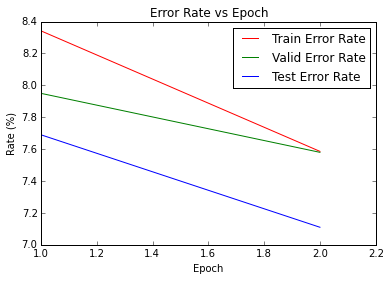

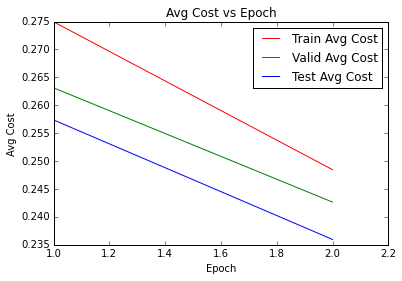

In [16]:
def plot_sweet_curve(xgrid, tab_train, tab_valid, tab_test, label_train, label_valid, label_test, x_label, y_label, title):
    f = interp1d(xgrid, tab_train, kind='linear')
    f2 = interp1d(xgrid, tab_valid, kind='linear')
    f3 = interp1d(xgrid, tab_test, kind='linear')

    plt.plot(xgrid,f(xgrid),'-',color='r')
    plt.plot(xgrid,f2(xgrid),'-',color='g')
    plt.plot( xgrid, f3(xgrid),'-',color='b')
    plt.legend([label_train, label_valid, label_test], loc='best')
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.title(title)
    plt.show()

epoch_file = open('output_data') #pour les résultats des derniers numéros

#epoch_file = open('optimal_data') #Les résultats pour configuration 1
epoch_data = pickle.load(epoch_file)

train_cost = epoch_data[:,0]
train_error_rate = epoch_data[:,1]

valid_cost = epoch_data[:,2]
valid_error_rate = epoch_data[:,3]

test_cost = epoch_data[:,4]
test_error_rate = epoch_data[:,5]

xgrid = [i+1for i in range(epoch_data.shape[0])] 
print train_error_rate
plot_sweet_curve(xgrid, train_error_rate, valid_error_rate, test_error_rate, "Train Error Rate", "Valid Error Rate", "Test Error Rate",  "Epoch", "Rate (%)","Error Rate vs Epoch")

plot_sweet_curve(xgrid, train_cost, valid_cost, test_cost, "Train Avg Cost", "Valid Avg Cost", "Test Avg Cost", "Epoch", "Avg Cost", "Avg Cost vs Epoch")



### Learning curves with Optimal Parameters

[ 4.168  2.684  2.046  1.73   1.336  1.014  0.822  0.706  0.634  0.566]


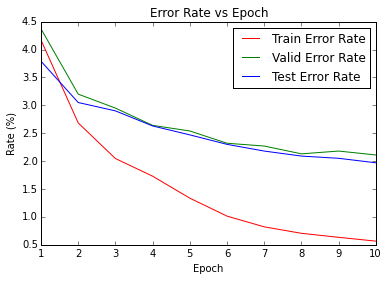

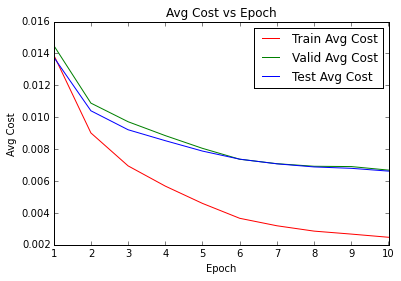

In [17]:
epoch_file = open('optimal_data') #Les résultats pour configuration 1
epoch_data = pickle.load(epoch_file)

train_cost = epoch_data[:,0]
train_error_rate = epoch_data[:,1]

valid_cost = epoch_data[:,2]
valid_error_rate = epoch_data[:,3]

test_cost = epoch_data[:,4]
test_error_rate = epoch_data[:,5]

xgrid = [i+1for i in range(epoch_data.shape[0])] 
print train_error_rate
plot_sweet_curve(xgrid, train_error_rate, valid_error_rate, test_error_rate, "Train Error Rate", "Valid Error Rate", "Test Error Rate",  "Epoch", "Rate (%)","Error Rate vs Epoch")

plot_sweet_curve(xgrid, train_cost, valid_cost, test_cost, "Train Avg Cost", "Valid Avg Cost", "Test Avg Cost", "Epoch", "Avg Cost", "Avg Cost vs Epoch")
